# Predict trend for each tag for the next 12 month

* I used SARIMA model to naively predict the amount of work for each tag for the next 12 month

## Observations: 
    * tags with an increasing trend: window, solar, hvac, gas
    * tags with a vaguely increasing trend: heat pump, furnace
    * tags didn't change much: insulation, boiler, heater
    * tags with a decreasing trend: None
* The predicted data are in 'predicts_by_tag.pkl'. It includes the last 11 months in existing data + the next 12 month

## Next:  
* Maybe look into regional trends by zip code?
* Need updates when the tagging gets updated. 

In [ ]:
import pandas as pd 
import pandas_profiling
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

In [2]:
df_tag = joblib.load('Data/df_tag.pkl')
df_tag.head(2)

,permitnumber,parcel_id,zip,worktype,year,month,tokens,tokens_filt,attic,basement,...,seal,sola,solar,stove,strip,volt,wall,water,window,tag
0,A100137,2204944000,02135,EXTREN,2013,1,amend permit per,none,0,0,...,0,0,0,0,0,0,0,0,0,other
1,A100764,502363000,02108,INTEXT,2012,1,interior exterior work indic draw amend permit,none,0,0,...,0,0,0,0,0,0,0,0,0,other


In [3]:
df_tag.groupby('tag').count()['permitnumber'].sort_values()

tag
heat pump          203
furnace           1853
hvac              2213
boiler            7335
solar             8637
water heater     11321
window           15082
insulation       15112
gas              25430
other           193840
Name: permitnumber, dtype: int64

In [4]:
permits = joblib.load('Data/draft_clean_permits.pkl')
# get date 
permits['date'] = pd.to_datetime(permits["issued_date"], infer_datetime_format=True).dt.date

In [5]:
# get datetime for rows in df_tag
df_tag['date'] = permits['date'][permits['permitnumber'].isin(df_tag['permitnumber'])].reset_index()['date']
# check
df_tag.groupby('tag').count()['permitnumber'].sort_values()

tag
heat pump          203
furnace           1853
hvac              2213
boiler            7335
solar             8637
water heater     11321
window           15082
insulation       15112
gas              25430
other           193840
Name: permitnumber, dtype: int64

In [18]:
# save this for furture analysis
#joblib.dump(df_tag, 'Data/df_tag_date.pkl')

['Data/df_tag_date.pkl']

In [6]:
def date_count(df_tag,tags):
    dt_df = pd.DataFrame(columns=df_tag.tag.unique()[1:])
    dt_df['date'] = df_tag.date.unique()
    for i in tags:
        count= df_tag[df_tag.tag==i].groupby('date')['permitnumber'].count()
        dt_df[i][dt_df.date.isin(count.index)] = count.values
    dt_df['date'] = pd.to_datetime(dt_df['date'], infer_datetime_format=True)    
    dt_df = dt_df.set_index('date')
    
    return(dt_df)
        
dt_df=date_count(df_tag,df_tag.tag.unique()[1:])  
dt_df.head(2)

,window,solar,hvac,heat pump,insulation,gas,boiler,furnace,water heater
date,,,,,,,,,
2013-01-03,2,NaN,1,NaN,2,12,2,NaN,1
2012-01-05,6,1,1,NaN,3,10,1,NaN,18


In [7]:
dt_df.fillna(0).sum().sort_values()

heat pump         203
furnace          1853
hvac             2213
boiler           7335
solar            8637
water heater    11321
window          15082
insulation      15112
gas             25430
dtype: int64

In [8]:
print('Earliest date: '  + str(dt_df.index.min()))
print('Lastest date: '  + str(dt_df.index.max()))

Earliest date: 2010-01-04 00:00:00
Lastest date: 2019-09-23 00:00:00


In [9]:
# resample by start of the month
y = dt_df.fillna(0).resample('MS').sum()

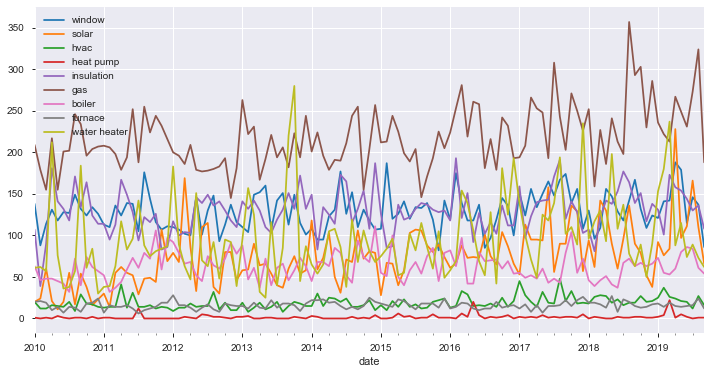

In [10]:
y.plot(figsize=(12, 6))
plt.show()

<Figure size 432x576 with 0 Axes>

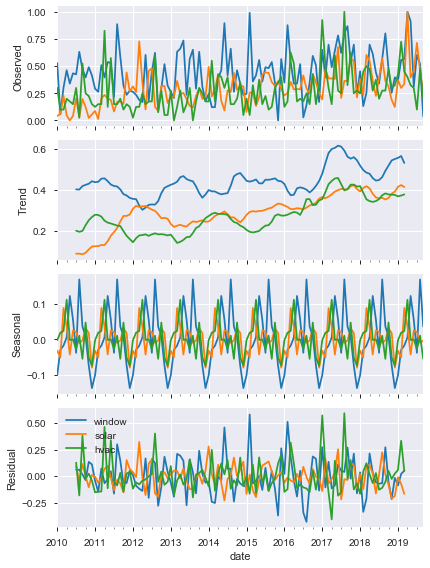

<Figure size 432x576 with 0 Axes>

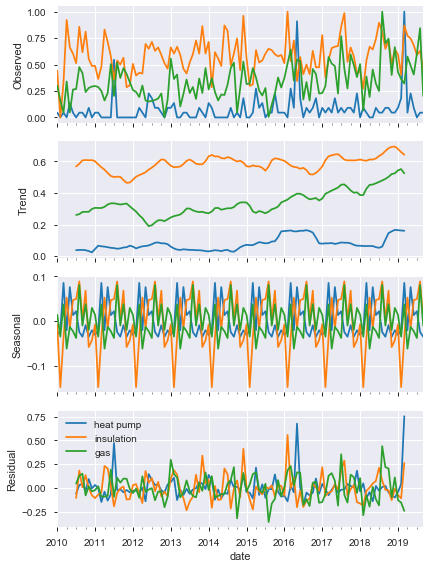

<Figure size 432x576 with 0 Axes>

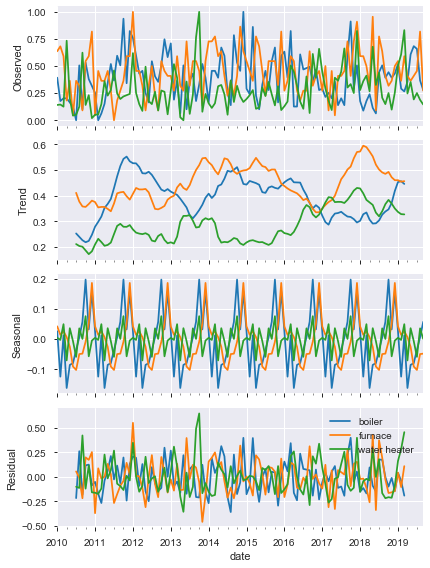

In [11]:
import itertools
import statsmodels.api as sm

from pylab import rcParams
rcParams['figure.figsize'] = (6, 8)

# plot the scaled dated to see them on same scales
y_scaled = (y -y.min())/(y.max() -y.min())

for i in [3,6,9] :
    decomposition = sm.tsa.seasonal_decompose(y_scaled.iloc[:,i-3:i], model='additive')
    plt.figure()
    decomposition.plot()
    plt.legend()
    plt.show()


In [ ]:
# observations: the data is quite noisy with lots irregular residuals. 

In [13]:
import pmdarima as pm

def tag_smodel(data,stats=True):
    '''
    Auto fit sarima model with 90% of the data. 
    Predict 10% of the data + the next 12 month, and plot the forecast.  
    Option to print model stats and diagnostic plots. (stats=True)
    '''
    train = data.iloc[:int(len(data)*0.90)] # use about 90% of the data to train
    smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
    if stats:
        print(smodel.summary())
        smodel.plot_diagnostics(figsize=(7,5))
        plt.tight_layout()
        plt.show()
    
    # Forecast
    n_periods = int(len(data)*0.10)+12
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(5,3))
    plt.plot(data)
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("SARIMA - Forecast of %s-tag" % data.name)
    plt.show()
    return(fitted_series)  
    
    

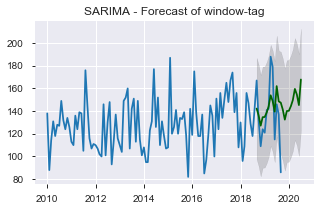

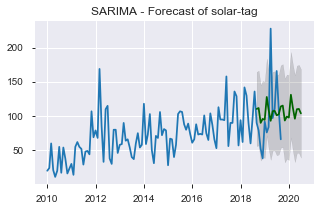

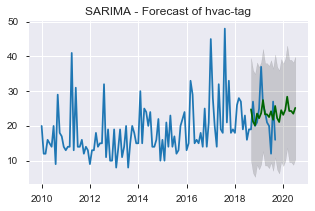

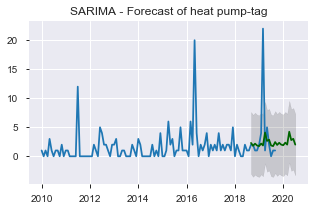

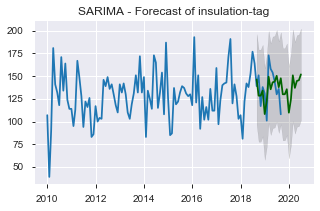

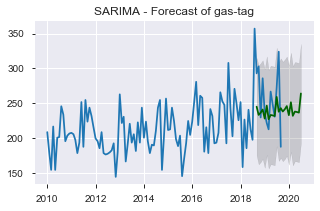

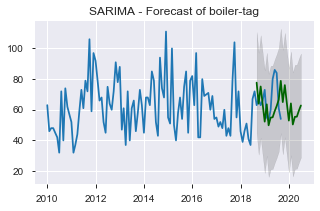

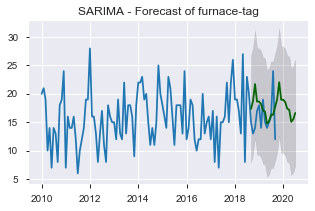

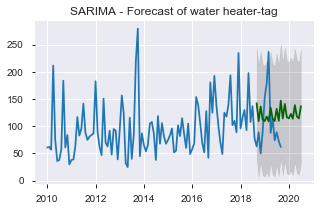

In [20]:
predicts = pd.DataFrame(columns =y.columns)
for i in y.columns:
    # if want to see the stats, pass 'True'
    predicts[i]=tag_smodel(y[i],False)

# Observations based on the plots:
* tags with an increasing trend: window, solar, hvac, gas
* tags with a vaguely increasing trend:  heat pump, furnace
* tags didn't change much: insulation, boiler, heater
* tags with a decreasing trend: None

In [15]:
#joblib.dump(predicts, 'Data/predicts_by_tag.pkl')

['Data/predicts_by_tag.pkl']